**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# Imports

In [1]:
from itertools import product
import numpy as np
from scipy import optimize
from scipy import interpolate
import sympy as sm
import matplotlib.pyplot as plt
import pandas as pd 
from scipy import linalg
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize_scalar, root_scalar

%load_ext autoreload
%autoreload 2

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

# Defining the parameters 

In [2]:
# Define the symbols

L = sm.symbols("L")
C = sm.symbols("C")
w = sm.symbols("w")
alpha = sm.symbols("alpha")
kappa = sm.symbols("kappa")
G = sm.symbols("G")
nu = sm.symbols("nu")
w_tilde = sm.symbols("w_tilde")
tau = sm.symbols("tau")
rho = sm.symbols("rho")
w_tilde = sm.symbols("w_tilde")
sigma = sm.symbols("sigma")
epsilon = sm.symbols("epsilon")



In [3]:
# Define the utility function
utility = sm.log(C**alpha * G**(1-alpha)) - nu * L**2 / 2

# Define the constraint equation
constraint = sm.Eq(C, kappa + (1 - tau) * w * L)

# Substitute the value of w_tilde in the constraint equation
constraint_subs = constraint.subs(w, w_tilde / (1 - tau))

# Isolate L from the budget constraint
C_from_con = sm.solve(constraint_subs, C)[0]

# Substitute the expression for C in the utility function
utility_subs = utility.subs(C, C_from_con)

# Find the first-order condition by differentiating the utility function with respect to L
foc = sm.diff(utility_subs, L)

# Solve the first-order condition equation for L
sol = sm.solve(sm.Eq(foc, 0), L)
sol[0]


(-kappa*nu - sqrt(nu*(4*alpha*w_tilde**2 + kappa**2*nu)))/(2*nu*w_tilde)

This solution is the same as the solution as we are asked to verify in the question 

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


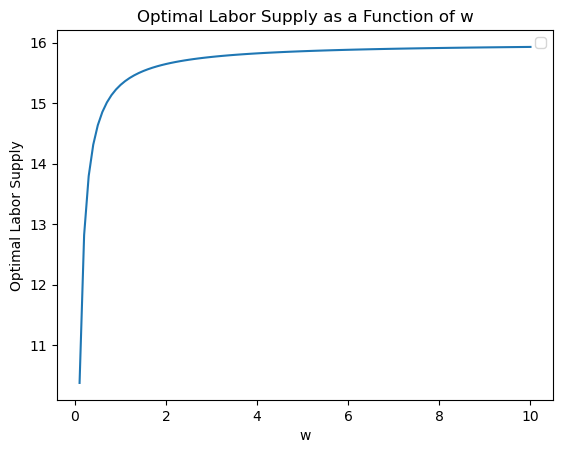

In [4]:
# 1. Defining the optimal labor function
def optimal_labor_supply(w, alpha, kappa, nu, tau):
    """""Define the optimal labor supply function

    Args: 

        w(float): the real wage 
        alpha(float): parameter 
        kappa(float): free privat consumption component 
        nu(float): disutility of labor scaling factor 
        tau(float): labor income tax-rate
    
    Returns: 
        the optimal labor supply function 
    

    """""
    
    #a. 
    w_tilde = (1 - tau) * w
    
    #b. 
    expression = (-kappa + np.sqrt(kappa**2 + 4 * alpha / nu * w_tilde**2)) / (2 * w_tilde)
    return expression

# 2. Setting the baseline parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
tau = 0.30

# 3. Defining the range of w values
w_values = np.linspace(0.1, 10, 100)

# 4. Computing the optimal labor supply
optimal_labor = optimal_labor_supply(w_values, alpha, kappa, nu, tau)

# 5 Plotting the results
plt.plot(w_values, optimal_labor)
plt.xlabel('w')
plt.ylabel('Optimal Labor Supply')
plt.title('Optimal Labor Supply as a Function of w')
plt.legend()
plt.show()


Here we can see that for a real wage between 0 and 2 the the labor supply increases substantially. From about a real wage of 2 and onwards there is marginal diminishing returns in labor supply and the optimal labor supply is about 15.8


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


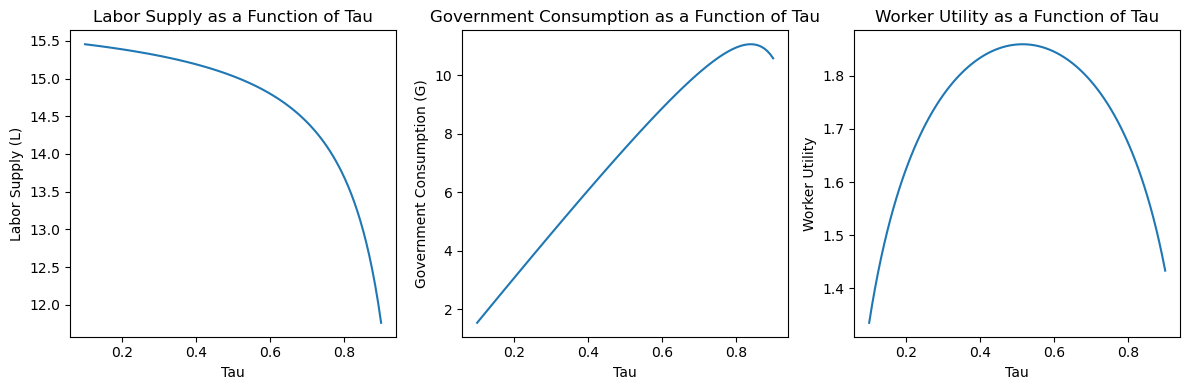

In [5]:
# 1 Defining the function for optimal labor supply
def optimal_labor_supply_w_tilde(w_tilde, alpha, kappa, nu):
    """ Defining the optimal labor supply function with w_tilde
    
    Args: 

        w_tilde:  w_tilde = (1 - tau) * w
        alpha(float): parameter 
        kappa(float): free privat consumption component 
        nu(float): disutility of labor scaling factor

    Returns: 

        expression(float): The optimal labor supply function with w_tilde  
    """
    #a 
    expression = (-kappa + np.sqrt(kappa**2 + 4 * alpha / nu * w_tilde**2)) / (2 * w_tilde)
    return expression

# 2 Defining the function for government consumption
def government_consumption(tau, w, alpha, kappa, nu):
    """"Defining the goverment consumption function 

    Args: 

        tau(float): labor income tax-rate
        w(float): the real wage 
        alpha(float): parameter 
        kappa(float): free privat consumption component 
        nu(float): disutility of labor scaling factor 
    
    Returns: 

        G(float) : the goverment consumption function 
       
    
    """
    #a
    w_tilde = (1 - tau) * w
    
    #b
    L_star = optimal_labor_supply_w_tilde(w_tilde, alpha, kappa, nu)
    
    #c
    G = tau * w * L_star
    return G

# 3 Defining the function for worker utility
def worker_utility(tau, w, alpha, kappa, G, nu):
    """
    Calculate the utility of a worker.

    Parameters:
        tau (float): Tax rate.
        w (float): Wage rate.
        alpha (float): Weight on consumption in utility.
        kappa (float): Fixed cost of working.
        G (float): Public good.
        nu (float): Coefficient of relative risk aversion.

    Returns:
        utility (float): Utility of the worker.
    """
    #a
    w_tilde = (1 - tau) * w
    
    #b
    L_star = optimal_labor_supply_w_tilde(w_tilde, alpha, kappa, nu)
    
    #c
    C = kappa + (1 - tau) * w * L_star
    
    #d
    utility = np.log(C**alpha * G**(1 - alpha)) - nu * L_star**2 / 2
    return utility

# 4 Setting the baseline parameters
alpha = 0.5
kappa = 1.0
nu = 1 / (2 * 16**2)
w = 1.0

# 5 Defining the grid of tau values
tau_values = np.linspace(0.1, 0.9, 100)

# 6 Computing the implied values for L, G, and utility for each tau value
L_values = []
G_values = []
utility_values = []

for tau in tau_values:
    w_tilde = (1 - tau) * w
    L_star = optimal_labor_supply_w_tilde(w_tilde, alpha, kappa, nu)
    G = government_consumption(tau, w, alpha, kappa, nu)
    utility = worker_utility(tau, w, alpha, kappa, G, nu)
    
    L_values.append(L_star)
    G_values.append(G)
    utility_values.append(utility)

# 7 Plotting the results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(tau_values, L_values)
plt.xlabel('Tau')
plt.ylabel('Labor Supply (L)')
plt.title('Labor Supply as a Function of Tau')

plt.subplot(1, 3, 2)
plt.plot(tau_values, G_values)
plt.xlabel('Tau')
plt.ylabel('Government Consumption (G)')
plt.title('Government Consumption as a Function of Tau')

plt.subplot(1, 3, 3)
plt.plot(tau_values, utility_values)
plt.xlabel('Tau')
plt.ylabel('Worker Utility')
plt.title('Worker Utility as a Function of Tau')

plt.tight_layout()
plt.show()


In the first plot we can see that the higher the tax-rate the lower the labor supply. 

In the second plot the Goverment consumption function is plottet for tau. Here we can see that the higher the tax the higher the consumption until it reaches 
the limit where there is no labor supply to pay taxes tau.

In the third plot the worker utility function of tau is plottet. It looks like a laffer curve where we can see that the optimal taxrate is approximately 50% 


**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

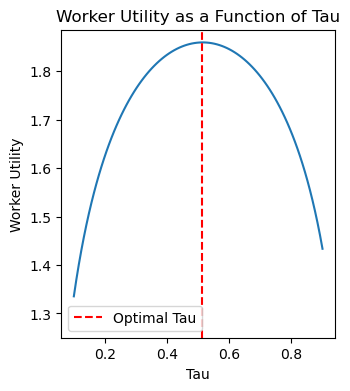

Optimal tau: 0.5121212121212121
Maximum worker utility: 1.8591882560448314


In [6]:
# 1 Finding the index of the maximum utility value
max_utility_index = np.argmax(utility_values)

# 2 Getting the optimal tau and maximum worker utility
tau_optimal = tau_values[max_utility_index]
worker_utility_max = utility_values[max_utility_index]

# 3 Plotting the results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 3)
plt.plot(tau_values, utility_values)
plt.axvline(x=tau_optimal, color='r', linestyle='--', label='Optimal Tau')
plt.xlabel('Tau')
plt.ylabel('Worker Utility')
plt.title('Worker Utility as a Function of Tau')
plt.legend()
plt.ylim(bottom=1.25)  # Set the lower limit of the y-axis to 0
plt.show()

print('Optimal tau:', tau_optimal)
print('Maximum worker utility:', worker_utility_max)


As mentioned in the last question the optimal tax-rate looked like it was close to 50% and we can hereby confirm that the optimal taxrate that optimizes worker utility is 51,212 %

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [7]:
# 1 Defining the utility function  
def objective_function_f(w, G, tau, alpha, kappa, sigma, rho, epsilon, nu):
    """Calculating the utility function value.

    Args:
        w (float): The real wage rate.
        G (float): Goverment consumption 
        tau (float): Tax rate.
        alpha (float): Weight on consumption in the objective function.
        kappa (float): The free private consumption component.
        sigma (float): Parameter for the utility function.
        rho (float): Parameter for the utility function.
        epsilon (float): Parameter for the utility function.
        nu (float): The disutility of labor scaling factor

    Returns:
        value (float): Value of the objective function.
    Raises:
        ValueError: If optimization fails.
    """
    # a  calculating the value of the inner objective function for a given labor supply
    def inner_objective(L):
        # i defining the consumption function 
        C = kappa + (1 - tau) * w * L
        # ii returning the utility function 
        return (((alpha * C**((sigma - 1) / sigma) + (1 - alpha) * G**((sigma - 1) / sigma))**(sigma / (sigma - 1)))**(1-rho) - 1 ) / (1 - rho) - nu * (L**(1+epsilon)) / (1+epsilon)
    # b Using a numerical solver to find the maximum of the inner objective function
    result = optimize.minimize_scalar(lambda L: -inner_objective(L), bounds=(0, 24), method='bounded')
    
    # c if-else statement for debugging
    if result.success:
        return -result.fun  # Return the negation of the maximum value
    else:
        raise ValueError("Optimization failed.")

# 2 Solving for optimal labor supply L* for a given set of parameters
def find_optimal_labor_supply(w, G, tau, alpha, kappa, sigma, rho, epsilon, nu):
    """Find the optimal labor supply.

    Args:
        w (float): The real wage rate.
        G (float): Goverment consumption 
        tau (float): Tax rate.
        alpha (float): Weight on consumption in the objective function.
        kappa (float): The free private consumption component.
        sigma (float): Parameter for the utility function.
        rho (float): Parameter for the utility function.
        epsilon (float): Parameter for the utility function.
        nu (float): The disutility of labor scaling factor

    Returns:
        L_star (float): Optimal labor supply.
    Raises:
        ValueError: If optimization fails.
    """
    # a Optimizing the labor supply 
    result = optimize.minimize_scalar(lambda L: -objective_function_f(w, G, tau, alpha, kappa, sigma, rho, epsilon, nu), bounds=(0, 24), method='bounded')
    
    # b if-else statement for debugging 
    if result.success:
        return result.x
    else:
        raise ValueError("Optimization failed.")

# 3 Solving for G that satisfies G = tau * w * L*
def find_G(w, tau, alpha, kappa, sigma, rho, epsilon, nu):
    """Find the value of G that satisfies G = tau * w * L*.

    Args:
        w (float): The real wage rate. 
        tau (float): Tax rate.
        alpha (float): Weight on consumption in the objective function.
        kappa (float): The free private consumption component.
        sigma (float): Parameter for the utility function.
        rho (float): Parameter for the utility function.
        epsilon (float): Parameter for the utility function.
        nu (float): The disutility of labor scaling factor

    Returns:
        G (float): Value of G.
    Raises:
        ValueError: If optimization or root finding fails.
    """
    # a defining the goverment consumption function
    def equation(G, L):
        return G - tau * w * L
    
    # b Defining the utility function for a given labor supply
    def objective_function(L):
        C = kappa + (1 - tau) * w * L
        return (((alpha * C**((sigma - 1) / sigma) + (1 - alpha) * G**((sigma - 1) / sigma))**(sigma / (sigma - 1)))**(1-rho) - 1 ) / (1 - rho) - nu * (L**(1+epsilon)) / (1+epsilon)
        
    # c Using a numerical solver to find the maximum of the inner objective function
    result = optimize.minimize_scalar(lambda L: -objective_function(L), bounds=(0, 24), method='bounded')
    
    # d if-else statement for debugging and returning the results
    if result.success:
        L_star = result.x
        result = optimize.root_scalar(lambda G: equation(G, L_star), method='brentq', bracket=[0, 1000])
        if result.converged:
            return result.root
        else:
            raise ValueError("Root finding failed.")
    else:
        raise ValueError("Optimization failed.")


# 4 Set_1 parameters
sigma1 = 1.001
rho1 = 1.001
epsilon = 1.0
tau1 = tau_optimal # Using the tau we found in question 4 

# 5 Set_2 parameters
sigma2 = 1.5
rho2 = 1.5
tau2 = tau_optimal # Using the tau we found in question 4 

# 6 Finding G for Set 1
G_set1 = find_G(w, tau1, alpha, kappa, sigma1, rho1, epsilon, nu)

# 7 Finding G for Set 2
G_set2 = find_G(w, tau2, alpha, kappa, sigma2, rho2, epsilon, nu)

# 8 Printing the results: 
print("G for Set 1:", G_set1)
print("G for Set 2:", G_set2)

G for Set 1: 7.676242924662147
G for Set 2: 4.146804874474422


We can hereby conclude that from the optimal labour the optimal consumption of G is: 
for Set 1: 7.676242924662147
for Set 2: 4.146804874474422

**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [8]:
# 1 Define the objective function
def objective_function(L, w, tau, G, alpha, kappa, sigma, rho, epsilon, nu):
    """Calculate the utility for a given labor supply.

    Args:
        L(float): labor supply
        w (float): The real wage rate. 
        tau (float): Tax rate.
        G (float): Goverment consumption
        alpha (float): Weight on consumption in the objective function.
        kappa (float): The free private consumption component.
        sigma (float): Parameter for the utility function.
        rho (float): Parameter for the utility function.
        epsilon (float): Parameter for the utility function.
        nu (float): The disutility of labor scaling factor

    Returns:
        utility
    """
    # a defining the consumption function 
    C = kappa + (1 - tau) * w * L
    return (((alpha * C**((sigma - 1) / sigma) + (1 - alpha) * G**((sigma - 1) / sigma))**(sigma / (sigma - 1)))**(1 - rho) - 1) / (1 - rho) - nu * (L**(1 + epsilon)) / (1 + epsilon)

# 2 Define the constraint function
def constraint_function(tau, w, L_star, G):
    """Calculate the constraint value.

    Args: 
        tau (float): Tax rate.
        w (float): The real wage rate.
        L_star(float): Optimal labor supply 
        G(float): Goverment consumption

    Returns:
    Constraint value
    """ 
    # a 
    return G - tau * w * L_star * ((1 - tau) * w)

# 3 Finding the socially optimal tax rate for Set_1
def objective_set1(tau):
    """Calculating the utility for a given tax rate in Set 1.

    Args:
        tau (float): Tax rate.

    Returns:
        utility
    """
    # a Find the optimal labor supply for the given tax rate
    L_star = optimize.minimize_scalar(lambda L: -objective_function(L, w, tau, tau * w * L * ((1 - tau) * w), alpha, kappa, sigma1, rho1, epsilon, nu), bounds=(0, 24), method='bounded').x
    # b Calculating the constraint value
    constraint_val = constraint_function(tau, w, L_star, tau * w * L_star * ((1 - tau) * w))
    # c Calculating the worker utility
    utility = objective_function(L_star, w, tau, tau * w * L_star * ((1 - tau) * w), alpha, kappa, sigma1, rho1, epsilon, nu)
    # d Penalty term for constraint violation - explanation futher down  
    penalty = 1e8 * np.maximum(0, -constraint_val)
    # e Return the negative utility (since we want to maximize)
    return -utility + penalty

# 4 Find the socially optimal tax rate for Set 1
result_set1 = optimize.minimize_scalar(objective_set1, bounds=(0, 1), method='bounded')

if result_set1.success:
    tau_star_set1 = result_set1.x
    print("Socially optimal tax rate for Set 1:", tau_star_set1)
else:
    raise ValueError("Optimization failed for Set 1.")

# 5 Finding the socially optimal tax rate for Set_2
def objective_set2(tau):
    """Calculating the utility for a given tax rate in Set 2.

    Args:
        tau (float): Tax rate.

    Returns:
        utility
    """
    # Finding the optimal labor supply for the given tax rate
    L_star = optimize.minimize_scalar(lambda L: -objective_function(L, w, tau, tau * w * L * ((1 - tau) * w), alpha, kappa, sigma2, rho2, epsilon, nu), bounds=(0, 24), method='bounded').x
    # Calculate the constraint value
    constraint_val = constraint_function(tau, w, L_star, tau * w * L_star * ((1 - tau) * w))
    # Calculate the worker utility
    utility = objective_function(L_star, w, tau, tau * w * L_star * ((1 - tau) * w), alpha, kappa, sigma2, rho2, epsilon, nu)
    # Penalty term for constraint violation
    penalty = 1e8 * np.maximum(0, -constraint_val)
    # Return the negative utility (since we want to maximize)
    return -utility + penalty

# 6 Finding the socially optimal tax rate for Set 2
result_set2 = optimize.minimize_scalar(objective_set2, bounds=(0, 1), method='bounded')

if result_set2.success:
    tau_star_set2 = result_set2.x
    print("Socially optimal tax rate for Set 2:", tau_star_set2)
else:
    raise ValueError("Optimization failed for Set 2.")

Socially optimal tax rate for Set 1: 0.3404554801711848
Socially optimal tax rate for Set 2: 0.29308352186939074


Penalty term explanation: 

So in the code we use: "np.maximum(0, -constraint_val)" this calculates the maximum value between 0 and the negative value of our "constraint_val." 

The purpose of this is to ensure that if our "constraint_val" is negative (i.e., the constraint is violated), the penalty term will be positive, and if our "constraint_val" is non-negative (i.e., the constraint is satisfied), the penalty term will be zero.

Here we then insert 1e8 which is a constant scaling factor used to amplify the penalty. It multiplies the result of np.maximum(0, -constraint_val) to make the penalty term relatively large in comparison to other components of the utility funciton.

Hereby when we multiply the penalty term with a large value, the utility function is penalized heavily when the constraint is violated, effectively discouraging solutions that do not satisfy the constraint. This encourages the optimization algorithm to prioritize solutions that satisfy the constraint.

The penalty term is then used in the utilityfunctions objective_set1 and objective_set2 to adjust the utility value. The higher the penalty, the more the utility is reduced when the constraint is violated, leading to a lower overall utility value for such solutions and therefore we can find the optimal solution that does satisfy the constraint. 

From this method we came to the conclusion that the Socially optimal tax rate for Set_1 and Set_2 are the above floats. 

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [9]:
# write your code here

We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [10]:
# write your code here 

Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [11]:
# write your code here

**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [12]:
# write your code here


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [13]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

In [14]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [15]:
# write your code here

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In [16]:
# write your code here